# RAM model

In [1]:
import sys
sys.path.append("..")

import torch

import model
import utils



# paths
plot_dir = "../plots/"
data_dir = "../data/"

# load images
imgs = []
paths = [data_dir + "./lenna.jpg", data_dir + "./cat.jpg"]
for i in range(len(paths)):
    img = utils.img2array(paths[i], desired_size=[512, 512], expand=True)
    imgs.append(torch.from_numpy(img))
imgs = torch.cat(imgs).permute((0, 3, 1, 2))

B, C, H, W = imgs.shape
l_t_prev = torch.FloatTensor(B, 2).uniform_(-1, 1)
h_t_prev = torch.zeros(B, 256)

ram = model.RecurrentAttention(64, 3, 2, C, 128, 128, 0.11, 256, 10)
h_t, l_t, _, _ = ram(imgs, l_t_prev, h_t_prev)

assert h_t.shape == (B, 256)
assert l_t.shape == (B, 2)


In [3]:
h_t.shape

torch.Size([2, 256])

In [4]:
l_t.shape

torch.Size([2, 2])

In [5]:
l_t

tensor([[-0.1607,  0.0038],
        [-0.2209,  0.0581]])

In [6]:
h_t_prev.shape

torch.Size([2, 256])

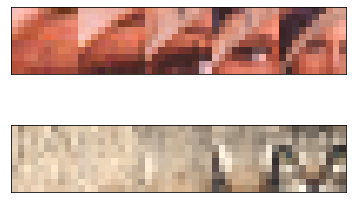

In [7]:
import sys
sys.path.append("..")

from functools import reduce

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

from modules import Retina
from utils import array2img, img2array



def bounding_box(x, y, size, color="w"):
    x = int(x - (size / 2))
    y = int(y - (size / 2))
    rect = patches.Rectangle(
        (x, y), size, size, linewidth=1, edgecolor=color, fill=False
    )
    return rect


# https://stackoverflow.com/questions/10657383/stitching-photos-together
def merge_images(image1, image2):
    """Merge two images into one, displayed side by side.
    """
    (width1, height1) = image1.size
    (width2, height2) = image2.size

    result_width = width1 + width2
    result_height = max(height1, height2)

    result = Image.new("RGB", (result_width, result_height))
    result.paste(im=image1, box=(0, 0))
    result.paste(im=image2, box=(width1, 0))
    return result


def main():
    # paths
    data_dir = "../data/"

    # load images
    imgs = []
    paths = [data_dir + "./lenna.jpg", data_dir + "./cat.jpg"]
    for i in range(len(paths)):
        img = img2array(paths[i], desired_size=[512, 512], expand=True)
        imgs.append(torch.from_numpy(img))
    imgs = torch.cat(imgs).permute(0, 3, 1, 2)

    # loc = torch.Tensor(2, 2).uniform_(-1, 1)
    loc = torch.from_numpy(np.array([[0.0, 0.0], [0.0, 0.0]]))

    num_patches = 5
    scale = 2
    patch_size = 10

    ret = Retina(g=patch_size, k=num_patches, s=scale)
    glimpse = ret.foveate(imgs, loc).data.numpy()

    glimpse = np.reshape(glimpse, [2, num_patches, 3, patch_size, patch_size])
    glimpse = np.transpose(glimpse, [0, 1, 3, 4, 2])

    merged = []
    for i in range(len(glimpse)):
        g = glimpse[i]
        g = list(g)
        g = [array2img(l) for l in g]
        res = reduce(merge_images, list(g))
        merged.append(res)

    merged = [np.asarray(l, dtype="float32") / 255.0 for l in merged]

    fig, axs = plt.subplots(nrows=2, ncols=1)
    for i, ax in enumerate(axs.flat):
        axs[i].imshow(merged[i])
        axs[i].get_xaxis().set_visible(False)
        axs[i].get_yaxis().set_visible(False)
    plt.show()


if __name__ == "__main__":
    main()
